In [1]:
from sklearn.datasets import make_blobs 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [12]:
X, y = make_blobs(n_samples=100, centers=None, n_features=3, random_state=0)

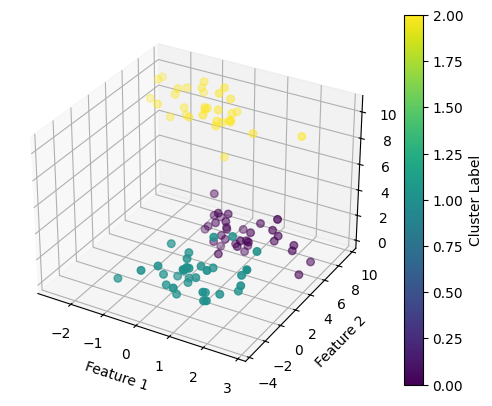

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=30)

# Adding axis labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.colorbar(scatter, ax=ax, label="Cluster Label")
plt.show()

In [2]:
def create_voxel_grid(points, grid_size=30):
    voxels = np.zeros((grid_size, grid_size, grid_size), dtype=bool)
    scaled_points = np.floor((points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0)) * (grid_size - 1)).astype(int)
    for point in scaled_points:
        voxels[point[0], point[1], point[2]] = True
    return voxels

In [4]:
#our base blob
X_base, Y = make_blobs(n_samples=100, centers=1, n_features=3, cluster_std=0.5, random_state=42)
voxel_base = create_voxel_grid(X_base)

#1 identical blob - same as base blob
voxel_identical = create_voxel_grid(X_base)

#2 similiar blob - with small noice
X_similar = X_base + np.random.normal(0, 0.2, X_base.shape)
voxel_similar = create_voxel_grid(X_similar)

#3 different blob - different center
X_different, _ = make_blobs(n_samples=100, centers=[[10, 10, 10]], n_features=3, cluster_std=0.5, random_state=42)
voxel_different = create_voxel_grid(X_different)

#4 blob with growth (narośl) - with new ponts
X_growth = np.vstack([X_base, X_base + [1, 1, 1]])
voxel_growth = create_voxel_grid(X_growth)

#5 blob with missing part - with removed points
X_missing = X_base[X_base[:, 0] < X_base[:, 0].mean()]  # Remove half the points based on x-coordinate
voxel_missing = create_voxel_grid(X_missing)


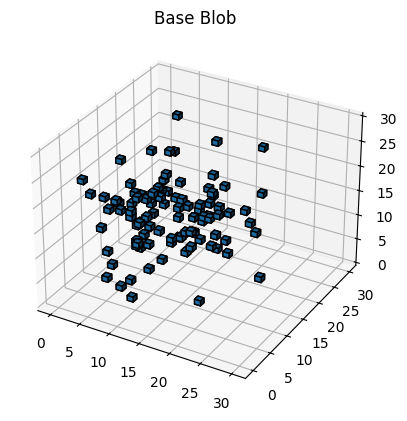

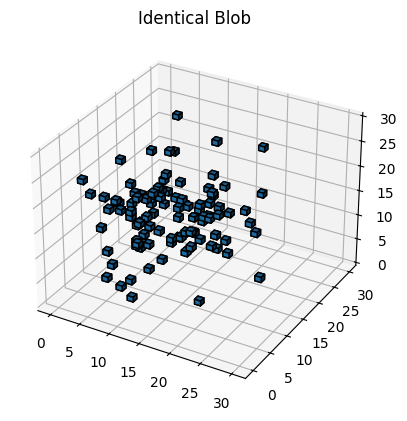

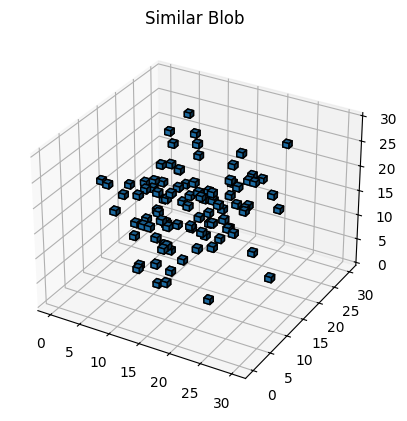

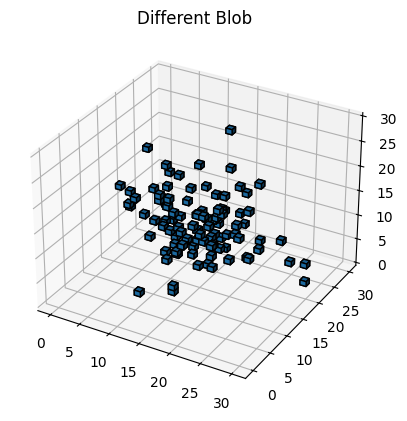

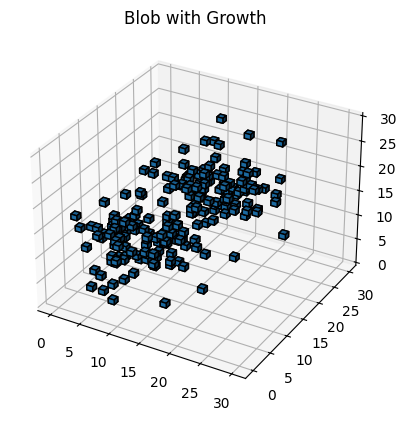

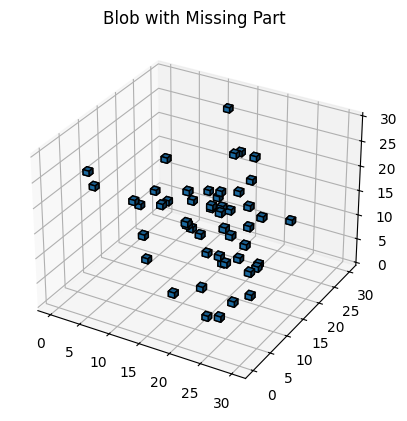

In [7]:
voxels = [voxel_base, voxel_identical, voxel_similar, voxel_different, voxel_growth, voxel_missing]
titles = ["Base Blob", "Identical Blob", "Similar Blob", "Different Blob", "Blob with Growth", "Blob with Missing Part"]

for i, voxel in enumerate(voxels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.voxels(voxel, edgecolor="k")
    ax.set_title(titles[i])
    plt.show()

In [6]:
plot_voxel(voxel_base, title="Basic Voxel Grid")
plot_voxel(voxel_identical, title="Identical Voxel Grid")
plot_voxel(voxel_similar, title="Similar Voxel Grid- with small noise")
plot_voxel(voxel_different, title="Different Voxel Grid- different center")
plot_voxel(voxel_growth, title="Growth Voxel Grid- with new points")
plot_voxel(voxel_missing, title="Missing Voxel Grid- with removed points")